# Image Segmentation with U-Net Model

## I. Download & Manipulate Dataset

### 1. Download dataset

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0VQBDV/oxford_iiit_pet-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0VQBDV/oxford_iiit_pet-test.tfrecord


Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

### 2. Load dataset

In [5]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SIZE)

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], IMAGE_SIZE)
    input_mask = tf.image.resize(datapoint['segmentation_mask'], IMAGE_SIZE)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

### 3. Separate the train-test dataset

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 128
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

## II. Dataset Ultility

### 1. Display the overall images

In [8]:
import numpy as np
def display(display_list, visible_mask = np.array([True, True, True, True])):
    plt.figure(figsize=(20, 20))
    title = ["Input Image", "True Mask", "Predicted Mask", "Remove Background"]
    title = tf.boolean_mask(title, visible_mask).numpy().astype('str')
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

### Mask convert

In [9]:
def convert_mask(t, target = 1.0):
    return tf.math.abs( 
        tf.math.subtract(
            t, 
            tf.convert_to_tensor(target, dtype=tf.float32) 
        ) 
    )

def remove_background(image, mask):
    msk = convert_mask(mask)
    return tf.math.multiply(image, msk)


### 3. Some example from train dataset

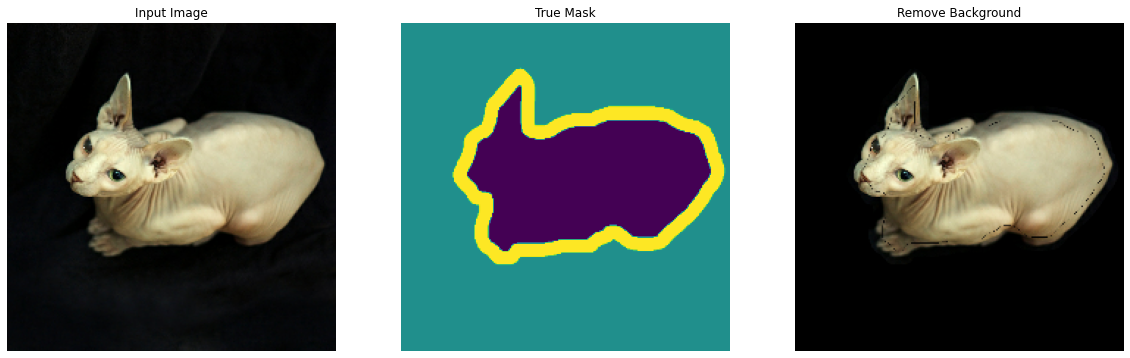

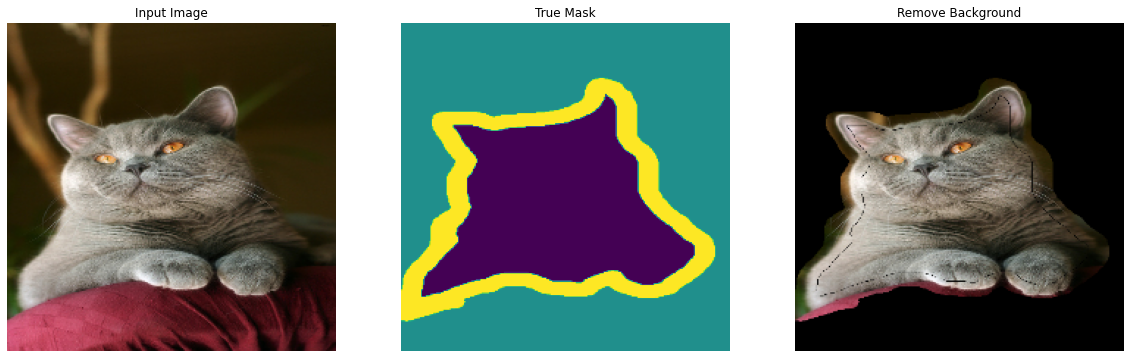

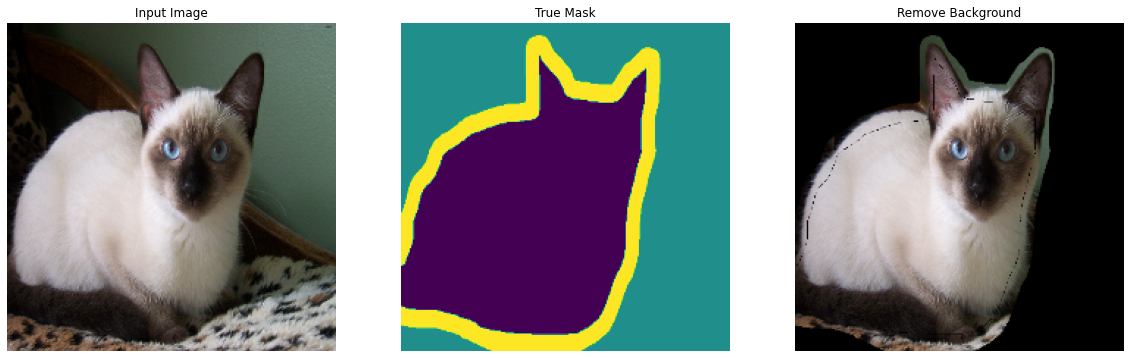

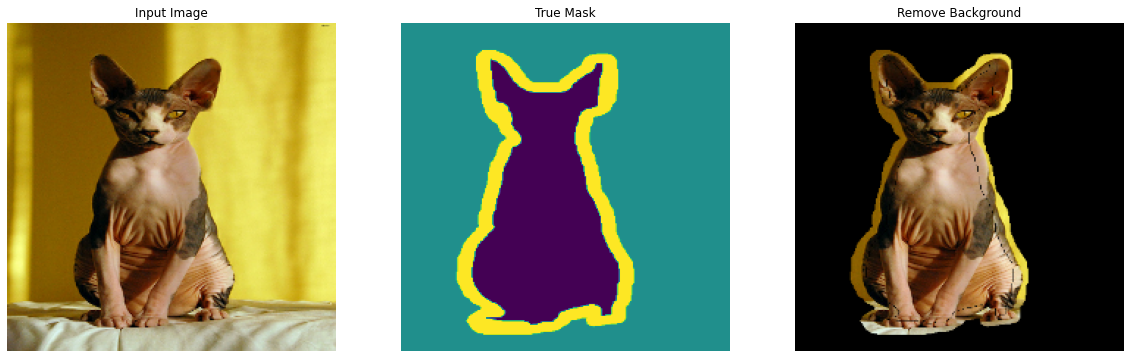

In [10]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
    result = remove_background(image, mask)
    display([sample_image, sample_mask, result], [True, True, False, True])

## III. Construct model

### 1. U-Net model use MobileNetV2 Encode-Decode

In [11]:
from tensorflow.keras.applications import MobileNetV2 as Pretrained_Model
from tensorflow.keras.layers import *

def unet_model_1(output_channels):

    base_model = Pretrained_Model(
        input_shape=INPUT_SHAPE, 
        include_top=False
    )

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_expand_relu',  # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(1024, 3),  # 4x4 -> 8x8
        pix2pix.upsample(512, 3),  # 8x8 -> 16x16
        pix2pix.upsample(256, 3),  # 16x16 -> 32x32
        pix2pix.upsample(128, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=INPUT_SHAPE)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same'
    )  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### 2. U-Net model use MobileNetV3Large Encode-Decode

In [12]:
from tensorflow.keras.applications import MobileNetV3Large as Pretrained_Model_2
from tensorflow.keras.layers import *

def unet_model_2(output_channels):

    base_model = Pretrained_Model_2(
        input_shape=INPUT_SHAPE, 
        include_top=False
    )

    for index, layer in enumerate(base_model.layers):
        layer._name = 'mylayer_' + str(index)

    # Use the activations of these layers
    layer_names = [
        'mylayer_16',   # 64x64
        'mylayer_28',   # 32x32
        'mylayer_89',   # 16x16
        'mylayer_178',  # 8x8
        'mylayer_273'   # 4x4
    ]

    layers = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

    down_stack.trainable = False

    up_stack = [
        pix2pix.upsample(1024, 3),  # 4x4 -> 8x8
        pix2pix.upsample(512, 3),  # 8x8 -> 16x16
        pix2pix.upsample(256, 3),  # 16x16 -> 32x32
        pix2pix.upsample(128, 3),   # 32x32 -> 64x64
    ]

    inputs = Input(shape=INPUT_SHAPE)
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same'
    )  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### 3. Self-made Unet

In [13]:
from tensorflow.keras.layers import *

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1, numberOfLayer = 2):
    input_layer = x
    for i in range(numberOfLayer):
        input_layer = Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(input_layer)
    return input_layer

def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1, numberOfLayer = 2):
    c = bottleneck(x, filters, kernel_size, padding, strides, numberOfLayer)
    p = MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1, numberOfLayer = 2):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = bottleneck(concat, filters, kernel_size, padding, strides, numberOfLayer)
    return c

In [14]:
def unet_model_3(channels):
    f = [32, 64, 128, 256, 512, 1024]
    numOfLayer = 4
    inputs = Input(INPUT_SHAPE)
    
    conv = []
    pool = inputs
    for i in range(len(f) - 1):
        c, pool = down_block(pool, f[1], numberOfLayer=numOfLayer)
        conv.append(c)

    # c1, p1 = down_block(p0, f[0]) #128 -> 64
    # c2, p2 = down_block(p1, f[1]) #64 -> 32
    # c3, p3 = down_block(p2, f[2]) #32 -> 16
    # c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(pool, f[-1])
    up = bn
    
    for i in range(len(f) - 2, 0, -1):
        up = up_block(up, conv.pop(), f[i], numberOfLayer=numOfLayer)

    # u1 = up_block(bn, c4, f[3]) #8 -> 16
    # u2 = up_block(u1, c3, f[2]) #16 -> 32
    # u3 = up_block(u2, c2, f[1]) #32 -> 64
    # u4 = up_block(u3, c1, f[0]) #64 -> 128

    # outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(up)
    outputs = Conv2DTranspose(channels, 3, strides=2, padding='same', activation='softmax')(up)

    model = tf.keras.models.Model(inputs, outputs)
    return model

## IV. Let's get started

### 0. Model Ultility

In [15]:
class ModelManager(object):

    def __init__(self):
        self._ModelRegistry_ = {}

    def is_key_exist(self, key):
        return key in self._ModelRegistry_.keys()

    def is_model_exist(self, model):
        return model in self._ModelRegistry_.values()

    def register_model(self, key, model):
        if self.is_key_exist(key):
            if self.__ModelRegistry_[key] == model:
                return model
            print("Key exist in registry and registered for another model!")
            return model

        if self.is_model_exist(model):
            if self._ModelRegistry_.index(model) == key:
                return model
            print('Model is already registred with index : ' + str(self._ModelRegistry_.index(model)))
            return model

        print('Register done!')
        self._ModelRegistry_[key] = model
        return model

    def get_model(self, key):
        return self._ModelRegistry_[key]

### 1. Register all models

In [16]:
manager = ModelManager()

manager.register_model('unet_mobilenetv2', unet_model_1(3)),
manager.register_model('unet_mobilenetv3', unet_model_2(3)),
manager.register_model('unet_diy', unet_model_3(3))

9412608/9406464 [==============================] - 0s 0us/step
Register done!
17612800/17605208 [==============================] - 0s 0us/step
Register done!
Register done!


### 2. Brief information of Model 

In [17]:
#@title Select a model to try { run: "auto", vertical-output: true, display-mode: "form" }
model_name = "unet_mobilenetv3" #@param ["unet_mobilenetv2", "unet_mobilenetv3", "unet_diy"] {allow-input: true}
print(model_name + " is choose!")

unet_mobilenetv3 is choose!


In [18]:
model = manager.get_model(model_name)

In [19]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Functional)            [(None, 112, 112, 64 4226432     input_4[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 14, 14, 1024) 11800576    model_2[0][4]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 14, 14, 1696) 0           sequential_4[0][0]               
                                                                 model_2[0][3]              

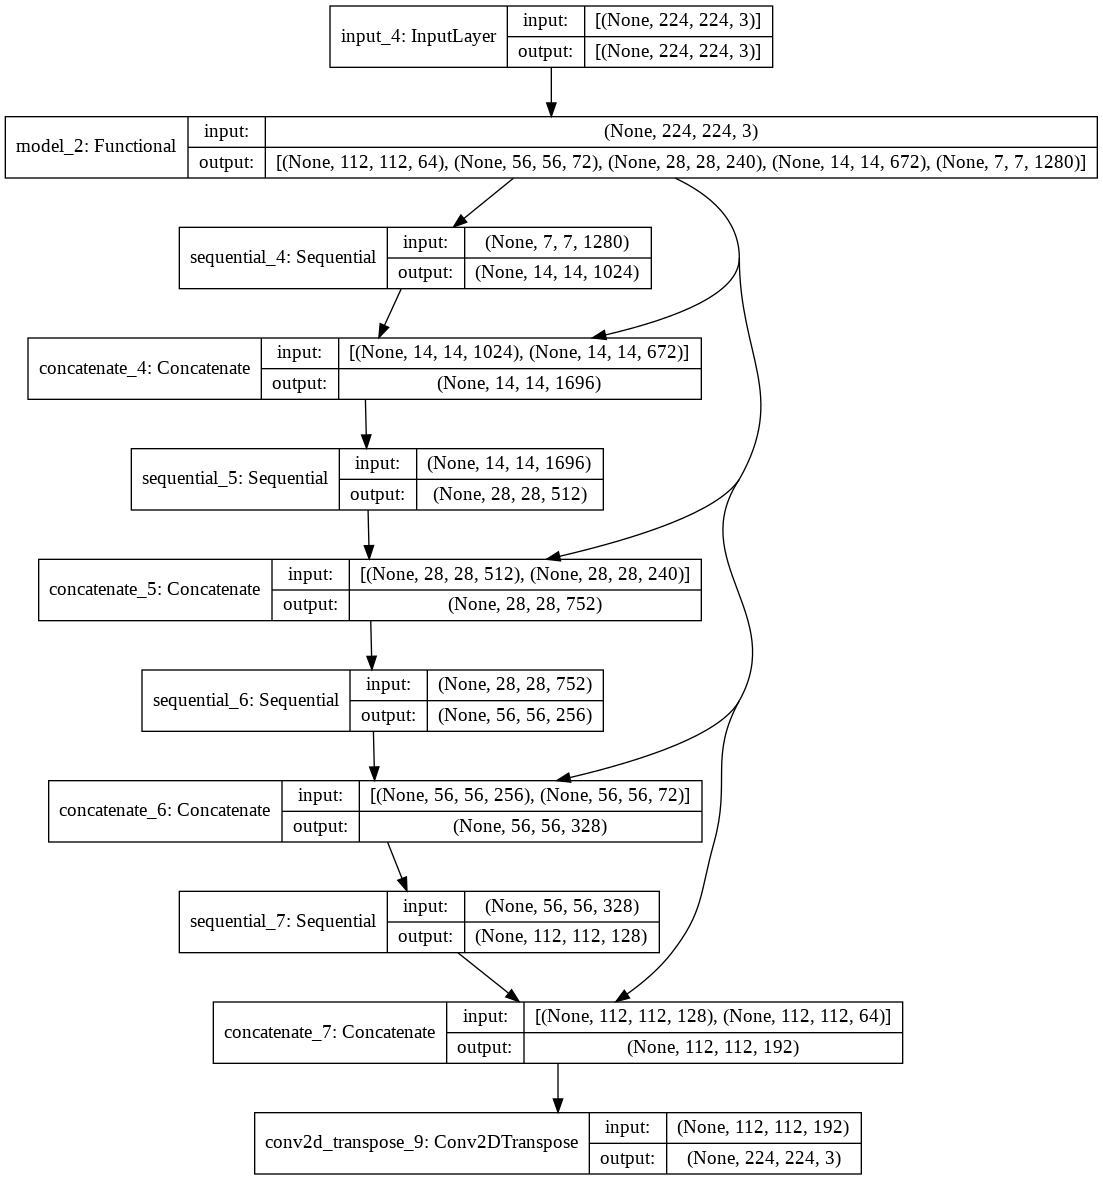

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

### 3. Training Model

In [21]:
OUTPUT_CHANNELS = 3
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

optimizer = tf.keras.optimizers.Adam(
    learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate = 0.01,
        decay_steps=10000,
        decay_rate=0.95,
        staircase=True
    )
)

loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metrics = ['accuracy']

In [22]:
model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = metrics
)

history = model.fit(
    train_dataset, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=test_dataset,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    ]
)

Epoch 1/50
28/28 [==============================] - 63s 2s/step - loss: 3.0286 - accuracy: 0.4597 - val_loss: 2.0187 - val_accuracy: 0.3537
Epoch 2/50
28/28 [==============================] - 48s 2s/step - loss: 1.0852 - accuracy: 0.5193 - val_loss: 0.9802 - val_accuracy: 0.5178
Epoch 3/50
28/28 [==============================] - 45s 2s/step - loss: 0.8986 - accuracy: 0.5861 - val_loss: 0.9585 - val_accuracy: 0.4705
Epoch 4/50
28/28 [==============================] - 46s 2s/step - loss: 0.8137 - accuracy: 0.6326 - val_loss: 1.5124 - val_accuracy: 0.4686
Epoch 5/50
28/28 [==============================] - 46s 2s/step - loss: 0.7515 - accuracy: 0.6864 - val_loss: 0.9496 - val_accuracy: 0.5947
Epoch 6/50
28/28 [==============================] - 47s 2s/step - loss: 0.7487 - accuracy: 0.6887 - val_loss: 0.8495 - val_accuracy: 0.6332
Epoch 7/50
28/28 [==============================] - 47s 2s/step - loss: 0.7539 - accuracy: 0.6864 - val_loss: 0.7806 - val_accuracy: 0.6716
Epoch 8/50
28/28 [==

### 4. Model Evaluation

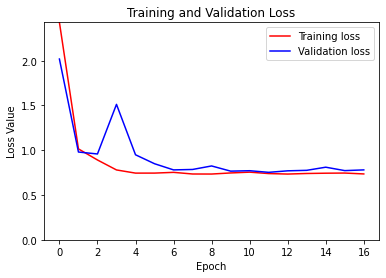

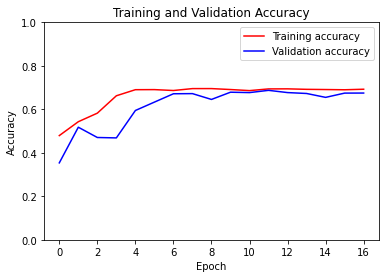

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, max(loss)])
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure()
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [24]:
model.evaluate(
    test_dataset, 
    batch_size=STEPS_PER_EPOCH
)

29/29 [==============================] - 23s 792ms/step - loss: 0.7776 - accuracy: 0.6764


[0.7776436805725098, 0.6764015555381775]

## V. Application in real example

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [26]:
def show_predictions(model, dataset=None, num=1):
   
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = create_mask(model.predict(image))
            result = remove_background(
                image[0],
                tf.cast(pred_mask, tf.float32)
            )
            display([image[0], mask[0], pred_mask, result])
    else:
        pred_mask =  create_mask(model.predict(sample_image[tf.newaxis, ...]))
        # result = remove_background(sample_image, pred_mask)
        display([sample_image, sample_mask, pred_mask])

### 1. From test dataset

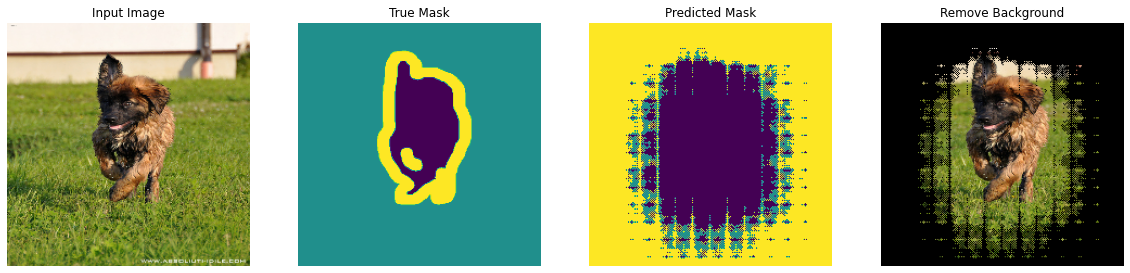

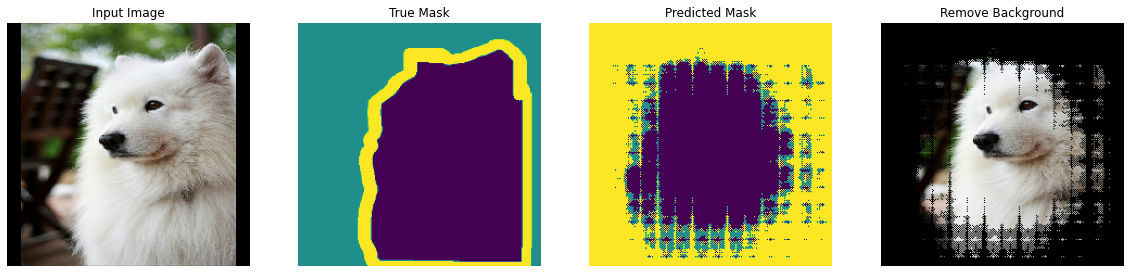

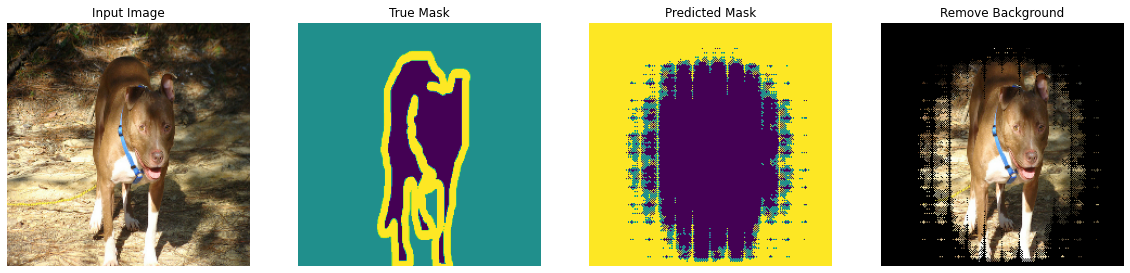

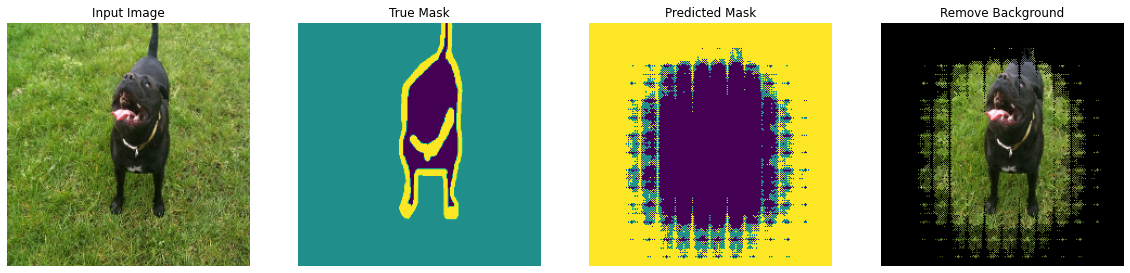

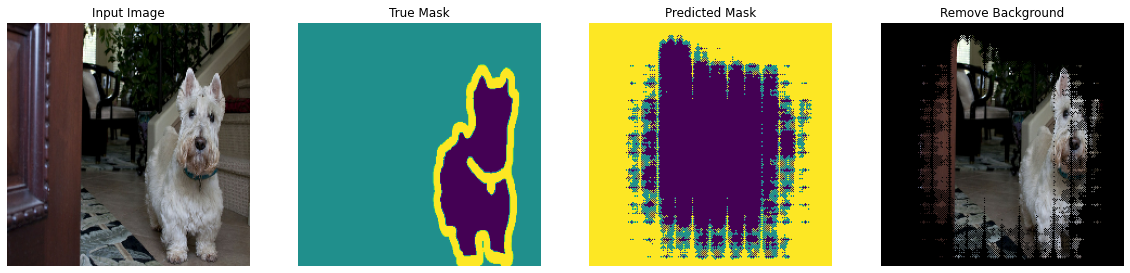

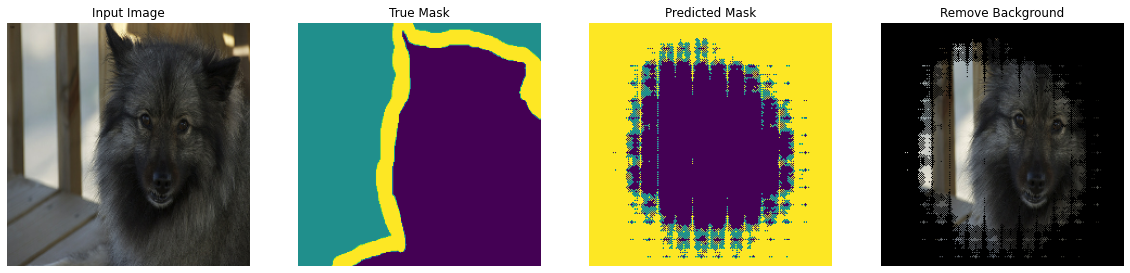

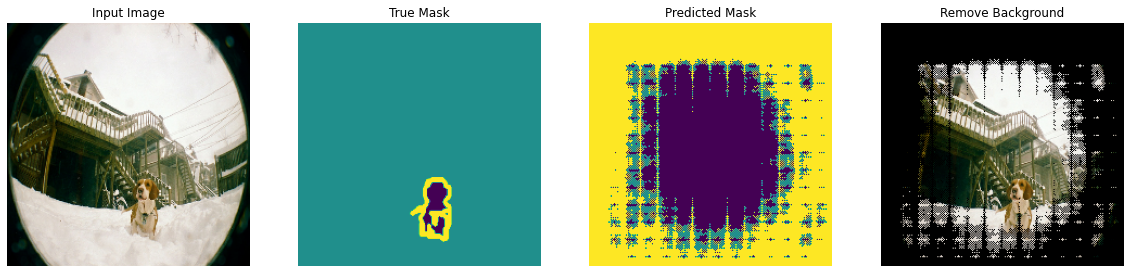

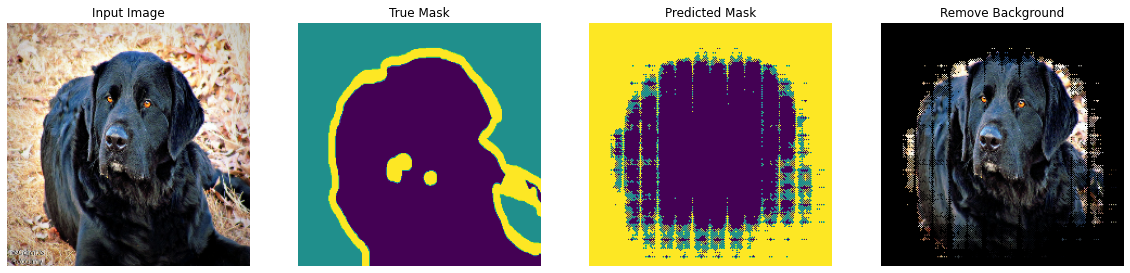

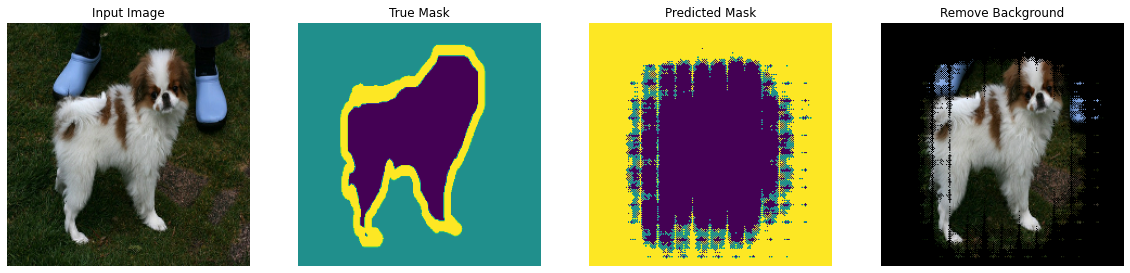

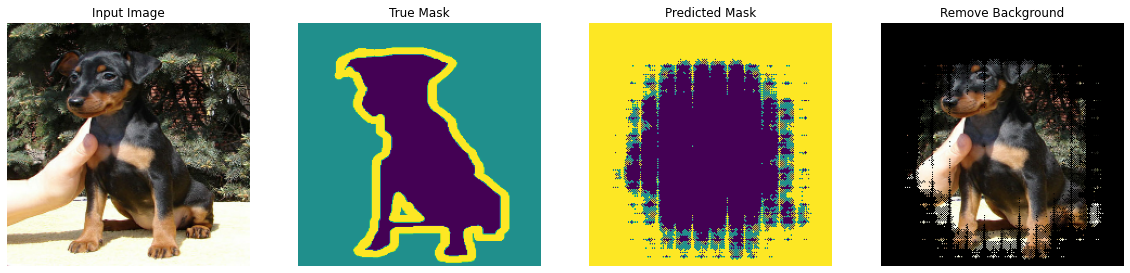

In [27]:
show_predictions(model, test_dataset, 10)

### 2. Let try your example 

Saving download.jpg to download.jpg
saved file download.jpg


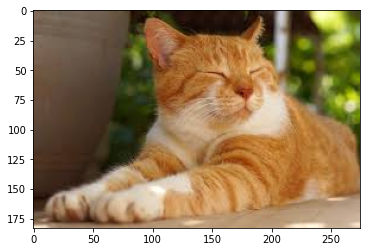

In [28]:
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab import files
uploaded = files.upload()

for name, data in uploaded.items():
  with open(name, 'wb') as f:
    f.write(data)
    print ('saved file', name)

img = cv.imread(name)
img_cvt=cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img_cvt)
plt.show()

In [29]:
resize_img = cv.resize(img, IMAGE_SIZE)

reshape_img = np.reshape(resize_img , (1, resize_img.shape[0], resize_img.shape[1], resize_img.shape[2]))

pred_mask = create_mask(model.predict(reshape_img))

result = remove_background(
    resize_img,
    tf.cast(pred_mask, tf.float32)
)

display([cv.cvtColor(resize_img, cv.COLOR_BGR2RGB), pred_mask, result], [True, False, True, True])